# Demo from  StatQuest: Random Forests in R, rewritten in Python
- This tutorial was originally introduced with R, and here, I tried to rewrite in Python.
- Goal: Practice data imputation
- Video: https://youtu.be/6EXPYzbfLCE
- Data source: https://archive.ics.uci.edu/ml/datasets/heart+disease

In [2]:
# load dependency
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Import suggested data
- Data: cleveland data ([link](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleveland.data))
- Names Definition: ([link](heart-disease.names))

In [4]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
column_names =  ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','hd']
df = pd.read_csv(url, names = column_names, na_values='?')
display(df)
print(df.info())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  hd        303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB
None


## Change Variates Type Accorting to the Definition
- Tip:
    1. Follow the video on StatQuest
    2. Categorical data can be converted to `category` without using `string` 
    3. Use `Int64` instead of `int64` to include `nan`
- Simplify `hd` column into only `Healthy` and `Unhealty`. `hd` contains 

In [15]:
# convert sex into M and F
df['sex'] = df['sex'].replace(1, 'M')
df['sex'] = df['sex'].replace(0, 'F')

# convert to integer
toint_colnms = ['ca', 'thal']
for toint_colnm in toint_colnms:
    df[toint_colnm] = df[toint_colnm].astype('Int64')

# convert hd to binary results
def check_class(x):
    if x == 0:
        new_x = 'Healthy'
    else:
        new_x = 'Unhealty'
    return new_x

df['hd'] = df['hd'].apply(func= check_class)

# convert string to categorical data
categoricals = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'hd']
toint_colnms.extend(categoricals)
categoricals = toint_colnms.copy()

for colnm in categoricals:
    df[colnm] = df[colnm].astype('category')

numericals = [x for x in df.columns if not x in categoricals]

categoricals = categoricals[:-1] # remove prediction column

print(categoricals)
print(numericals)

['ca', 'thal', 'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope']
['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


In [16]:
# print unique for validation
for col in df:
    print(df[col].unique())

[63. 67. 37. 41. 56. 62. 57. 53. 44. 52. 48. 54. 49. 64. 58. 60. 50. 66.
 43. 40. 69. 59. 42. 55. 61. 65. 71. 51. 46. 45. 39. 68. 47. 34. 35. 29.
 70. 77. 38. 74. 76.]
['M', 'F']
Categories (2, object): ['F', 'M']
[1.0, 4.0, 3.0, 2.0]
Categories (4, float64): [1.0, 2.0, 3.0, 4.0]
[145. 160. 120. 130. 140. 172. 150. 110. 132. 117. 135. 112. 105. 124.
 125. 142. 128. 170. 155. 104. 180. 138. 108. 134. 122. 115. 118. 100.
 200.  94. 165. 102. 152. 101. 126. 174. 148. 178. 158. 192. 129. 144.
 123. 136. 146. 106. 156. 154. 114. 164.]
[233. 286. 229. 250. 204. 236. 268. 354. 254. 203. 192. 294. 256. 263.
 199. 168. 239. 275. 266. 211. 283. 284. 224. 206. 219. 340. 226. 247.
 167. 230. 335. 234. 177. 276. 353. 243. 225. 302. 212. 330. 175. 417.
 197. 198. 290. 253. 172. 273. 213. 305. 216. 304. 188. 282. 185. 232.
 326. 231. 269. 267. 248. 360. 258. 308. 245. 270. 208. 264. 321. 274.
 325. 235. 257. 164. 141. 252. 255. 201. 222. 260. 182. 303. 265. 309.
 307. 249. 186. 341. 183. 407. 217. 28

/var/folders/vf/l7rd9tzn7r1drqsc_wjr41mw0000gn/T/ipykernel_79219/3738655513.py:2: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  print(df[col].unique())


## Imputation
- Must read: https://scikit-learn.org/stable/modules/impute.html
    - Quote: 
    
        > There are many well-established imputation packages in the R data science ecosystem: Amelia, mi, mice, missForest, etc. missForest is popular, and turns out to be a particular instance of different sequential imputation algorithms that can all be implemented with IterativeImputer by passing in different regressors to be used for predicting missing feature values. In the case of missForest, this regressor is a Random Forest. See Imputing missing values with variants of IterativeImputer.

    - **IterativeImputer is missForest!!**
    
    - IterativeImputer is unhappy about categorical data, unfortunately. We cannot just pool them together (unlike R).
    - We have to treat categorical data and numerical data seperately.
    - Estimator is the kernel of `IterativeImputer`, which by default is `BayesianRidge()`. I changed them to the following: 
        1. Numerical data: `RandomForestRegressor()`
        2. Categorical data: `RandomForestClassifier()` 
        
- Steps:
    1. Convert categorical data to labels ([link](https://stackoverflow.com/questions/54444260/labelencoder-that-keeps-missing-values-as-nan)). It is important to preserve nan. The document of `LabelEncoder` is [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).
    2. Build X and y
    3. Fit imputer using `IterativeImputer`
    4. Run fit and transform

## Reference
- Videos: [StatQuest: Random Forests Part 2: Missing data and clustering](https://youtu.be/sQ870aTKqiM)
- Readings: 
    1. [Iterative Imputation for Missing Values in Machine Learning](https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/)
    2. [A Better Way to Handle Missing Values in your Dataset: Using IterativeImputer (PART I)](https://towardsdatascience.com/a-better-way-to-handle-missing-values-in-your-dataset-using-iterativeimputer-9e6e84857d98)
    

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

seed = 1947

# convert categorical data into labels using LabelEncoder
df[categoricals] = df[categoricals].apply(lambda series: pd.Series(
        LabelEncoder().fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
    ))

# make X and y
y = df['hd']
X = df.drop(['hd'], axis = 1)

# Run imputation on numerical and categorical data
imp_num = IterativeImputer(estimator=RandomForestRegressor(),
                               initial_strategy='mean',
                               max_iter=10, random_state=seed)
imp_cat = IterativeImputer(estimator=RandomForestClassifier(), 
                            initial_strategy='most_frequent',
                            max_iter=10, random_state=seed)

X[numericals] = imp_num.fit_transform(X[numericals])
X[categoricals] = imp_cat.fit_transform(X[categoricals])

display(X)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,0.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,2.0,0.0,1.0
1,67.0,1.0,3.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,1.0,3.0,0.0
2,67.0,1.0,3.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,1.0,2.0,2.0
3,37.0,1.0,2.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,2.0,0.0,0.0
4,41.0,0.0,1.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,0.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,1.0,0.0,2.0
299,68.0,1.0,3.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,1.0,2.0,2.0
300,57.0,1.0,3.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,1.0,1.0,2.0
301,57.0,0.0,1.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,1.0,1.0,0.0


## Modeling
- Train and test split using `train_test_split`
- Use `RandomForestClassifier` for classification
- Ensure `random_state` are both defined for reproducibility 


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

split_randonstate = 1947
model_randonstate = 1949

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = split_randonstate)
model = RandomForestClassifier(n_estimators = 1000, max_depth = 50, oob_score = True, n_jobs = 6, random_state = model_randonstate, verbose = 2)
model.fit(x_train, y_train)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.2s


building tree 1 of 1000building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000

building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.4s


building tree 393 of 1000building tree 394 of 1000

building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tree 399 of 1000
building tree 400 of 1000
building tree 401 of 1000
building tree 402 of 1000
building tree 403 of 1000
building tree 404 of 1000
building tree 405 of 1000
building tree 406 of 1000
building tree 407 of 1000
building tree 408 of 1000
building tree 409 of 1000
building tree 410 of 1000
building tree 411 of 1000
building tree 412 of 1000
building tree 413 of 1000
building tree 414 of 1000
building tree 415 of 1000
building tree 416 of 1000
building tree 417 of 1000
building tree 418 of 1000
building tree 419 of 1000
building tree 420 of 1000
building tree 421 of 1000
building tree 422 of 1000
building tree 423 of 1000
building tree 424 of 1000
building tree 425 of 1000
building tree 426 of 1000
building tree 427 of 1000
building tree 428 of 1000
building tree 429 of 1000
building tree 430 of 1000
building tre

[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.7s


building tree 782 of 1000
building tree 783 of 1000
building tree 784 of 1000
building tree 785 of 1000
building tree 786 of 1000
building tree 787 of 1000
building tree 788 of 1000
building tree 789 of 1000
building tree 790 of 1000
building tree 791 of 1000
building tree 792 of 1000
building tree 793 of 1000
building tree 794 of 1000
building tree 795 of 1000
building tree 796 of 1000
building tree 797 of 1000
building tree 798 of 1000
building tree 799 of 1000
building tree 800 of 1000
building tree 801 of 1000
building tree 802 of 1000
building tree 803 of 1000
building tree 804 of 1000
building tree 805 of 1000
building tree 806 of 1000
building tree 807 of 1000
building tree 808 of 1000
building tree 809 of 1000
building tree 810 of 1000
building tree 811 of 1000
building tree 812 of 1000
building tree 813 of 1000
building tree 814 of 1000
building tree 815 of 1000
building tree 816 of 1000
building tree 817 of 1000
building tree 818 of 1000
building tree 819 of 1000
building tre

[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    1.1s finished


RandomForestClassifier(max_depth=50, n_estimators=1000, n_jobs=6,
                       oob_score=True, random_state=1949, verbose=2)

In [26]:
# Run accuracy score and confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_test = model.predict(x_test)
accuracy_score(y_test, y_pred_test)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.1s finished


0.8360655737704918

In [27]:
confusion_matrix(y_test, y_pred_test)

array([[31,  6],
       [ 4, 20]])

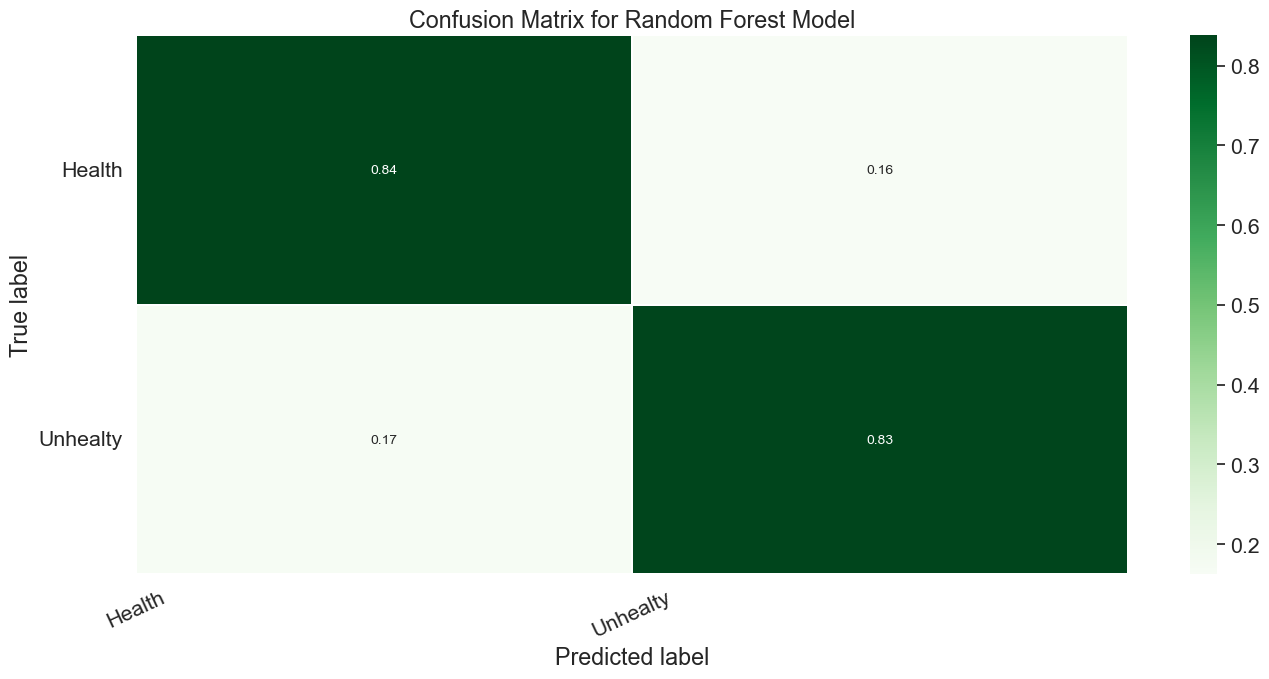

In [28]:
import seaborn as sns
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Health', 'Unhealty']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()